In [1]:
import os
import sys
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.patches as patches
import colorcet as cc

In [ ]:
"""
This code analyzes the mapping between BG clusters and those defined by Siletti et al.

It consists of two distinct parts. Although the code may appear redundant, each part follows a different logic, and it was clearer to keep them in separate cells.

The first part examines the overlap between BG clusters identified as significant in our analysis and their counterparts in Siletti’s taxonomy. The goal is to assess whether the groups we identify are finer or broader than those defined by Duncan et al.

The second part focuses on the overlap between significant clusters reported by Duncan et al. and their corresponding clusters in the BG taxonomy. Here, the goal is to detect potentially relevant clusters that may have been missed in our own analysis.
"""

In [ ]:
## PARAMETERS: 
species = "Human"
pipeline = "AIBS"

work_dir = f"/allen/programs/celltypes/workgroups/rnaseqanalysis/HMBA/Aim1_Atlases/{species}/BasalGanglia"
os.chdir(work_dir)

adata = sc.read_h5ad(work_dir + "/Human_basalganglia_HMBA_AIT19-5_anno_latest.h5ad")

manual_order =[
  "STRd D1 Matrix MSN", "STRd D1 Striosome MSN", "STRv D1 MSN", "STRv D1 NUDAP MSN",
  "STRd D2 Matrix MSN", "STRd D2 Striosome MSN", "STRv D2 MSN", "STRd D2 StrioMat Hybrid MSN",
  "STRd D1D2 Hybrid MSN", "OT D1 ICj", "Unknown-MSN", 
  "GP MEIS2-SOX6 GABA", "STR FS PTHLH-PVALB GABA", "STR TAC3-PLPP4 GABA", "STR TAC3-PLPP4-LHX8 GABA",
  "STR SST-ADARB2 GABA", "STR SST-CHODL GABA", "STR SST-RSPO2 GABA", "STR LYPD6-RSPO2 GABA", "BG LAMP5-LHX6 GABA",
  "Cholinergic_1 GABA", "Cholinergic_2 GABA", "Cholinergic_3 GABA", "GP SOX6-CTXND1 GABA", 
  "NDB-SI LHX6-LHX8-GBX1 GABA", "NDB-SI LHX8-STK32A GABA", "REGION CALCR GABA", "GPi Core",
  "VTA GABA", "SN GATA3-PVALB GABA", "SN-VTA GATA3-TCF7L2 GABA", "SN EBF2 GABA", 
  "SN SEMA5A GABA", "SN-STH HDC Hist", "STR VIP GABA", "BG LAMP5-CXCL14 GABA", "Unknown-CGEgaba",
  "OB Dopa-Gaba", "OB-in Frmd7 Gaba",
  "GPi Shell", "BG SKOR1 Glut", "BG POSTN Glut", "Eca EBF2 Glut", "REGION FOXB1 Glut",
  "REGION PITX2 Glut", "REGION SCN5A Glut", "REGION TBR1 Glut", "STH PVALB-PITX2 Glut",
  "REGION SHOX2 Glut", "VTA Glut", "SN SOX6 Dopa", "SN CALB1 Dopa", "SN GAD2 Dopa",
  "STR Astrocyte", "BG Astrocyte", "ImAstro", "Ependymal", "Oligo OPALIN", "Oligo RBFOX1", "COP", 
  "OPC", "ImOligo", "Microglia", "BAM", "T cells", "B cells", "Monocyte", "Endo", "Pericyte", "SMC", "VLMC", 
  "ACB-BST-FS D1 Gaba", "CEA-AAA-BST Gaba", "CEA-BST Gaba", "MEA-BST Gaba", "MEA-BST Sox6 Gaba", 
  "RHP-COA Ndnf Gaba", "LSX GABA", "CTX PVALB Chandelier GABA", "RT-ZI Gaba", 
  "CA1-ProS Glut", "DG Glut", "MY Glut NFIB", "PG-TRN-LRN Fat2 Glut"
]

In [3]:
#### ORDER for the other levels
# Get each cluster's corresponding Group label
cluster_df = adata.obs[["cluster_id", "Group"]].drop_duplicates()
# Convert Group to a categorical type using the manual order
cluster_df["Group"] = pd.Categorical(cluster_df["Group"], categories=manual_order, ordered=True)
# Sort clusters first by Group (based on manual order), then by cluster_id within each Group
cluster_df = cluster_df.sort_values(by=["Group", "cluster_id"])
# Extract the final ordered list of cluster_ids
cluster_id_order = cluster_df["cluster_id"].tolist()

In [ ]:
def plot_confusion_matrix_sort_on_BG(
   adata,
   group_col="Group",
   label_col="siletti_label",
   manual_order=None,
   reorder_cols="greedy",  # Options: "greedy", "cluster", "none"
   purity_thresh=0.9,
   rotate_plot=False,      # Rotate heatmap view (flip x and y axis)
   figsize=(8, 14),
   cmap="YlGnBu",
   save_path=None,         # Save output path
   show_colorbar=True,     # Show or hide the colorbar
   min_mapping_threshold=None,  # NEW: filter labels never mapped > threshold
   B_G_significant=None, ## FILTER ON DUNCAN's HITS
   Duncan_list=None
):
   """
   Plot a confusion matrix between BG cell type grouping and mapped reference labels (Siletti et al.). 
   Colorbars indicate the groups and the supercluster  to which the groupings belong. 
   A second colorbar (for the rows) indicates whether the Siletti et al.'s cluster has a significant association in Duncan et al.



   Parameters
   ----------
   adata : AnnData
       The annotated data object containing obs columns for group and reference mapping.
   group_col : str
       The column in adata.obs for your cell type labels (rows of confusion matrix).
   label_col : str
       The column in adata.obs for mapped reference labels (columns of confusion matrix).
   manual_order : list or None
       Optional list specifying the order of group_col (rows).
   reorder_cols : str
       Column ordering method: "greedy", "cluster", or "none".
   purity_thresh : float
       Threshold for marking high-purity rows with a star.
   rotate_plot : bool
       If True, transpose the matrix only for visualization (flip axes).
   figsize : tuple
       Size of the figure (width, height).
   cmap : str
       Colormap for the heatmap.
   save_path : str or None
       If provided, saves the plot to this file path.
   show_colorbar : bool
       Whether to show the heatmap colorbar (legend).
   min_mapping_threshold : float or None
       If set, filters out label columns where no group maps above this threshold.
   B_G_significant : list of strings
       List of Basal Ganglia groupings which are significant in our analysis.
    Duncan_list : list of strings
        List of Siletti et al's groupings which are significant in the Duncan et al.

   """



   import pandas as pd
   import seaborn as sns
   import matplotlib.pyplot as plt


   ### I/ Prepare the Confusion Matrix:

   # Step 1: Construct confusion matrix (normalized)
   confusion_raw = pd.crosstab(adata.obs[group_col], adata.obs[label_col])
   confusion_norm = confusion_raw.div(confusion_raw.sum(axis=1), axis=0)
   confusion_norm = confusion_norm[confusion_norm.sum(axis=1) > 0]  # remove empty rows

   if B_G_significant is not None:
    B_G_significant = list(map(str, B_G_significant))  # ensure all labels are strings
    #available_labels = confusion_norm.columns.astype(str)
    available_labels = confusion_norm.index.astype(str)
    matched_labels = [label for label in B_G_significant if label in available_labels.tolist()]

    if not matched_labels:
        raise ValueError(
            f"None of the labels in `label_include_list` matched the confusion matrix columns.\n"
            f"Available labels: {available_labels.tolist()}\n"
            f"Requested labels: {B_G_significant}"
        )

    print(f"Keeping {len(matched_labels)} out of {len(B_G_significant)} requested labels.")
    #confusion_norm = confusion_norm.loc[:, matched_labels]  # TO FILTER THE SILETTI
    confusion_norm = confusion_norm.loc[matched_labels, :] # TO FILTER THE BG

   # Apply row order if provided
   if manual_order is not None:
       confusion_norm = confusion_norm.reindex([x for x in manual_order if x in confusion_norm.index])

   # Optional: filter labels never reaching mapping threshold
   if min_mapping_threshold is not None:
       filtered_cols = confusion_norm.columns[(confusion_norm > min_mapping_threshold).any(axis=0)]
       confusion_norm = confusion_norm[filtered_cols]

   # Step 2: Column reordering
   if reorder_cols == "greedy":
       best_match_per_row = confusion_norm.idxmax(axis=1)
       seen = set()
       ordered_labels = []
       for label in best_match_per_row:
           if label not in seen:
               ordered_labels.append(label)
               seen.add(label)
       remaining_labels = [label for label in confusion_norm.columns if label not in seen]
       final_label_order = ordered_labels + remaining_labels
       confusion_norm = confusion_norm[final_label_order]


   elif reorder_cols == "cluster":
       from scipy.cluster.hierarchy import linkage, leaves_list
       from scipy.spatial.distance import pdist
       col_linkage = linkage(pdist(confusion_norm.T, metric="euclidean"), method="average")
       col_order = leaves_list(col_linkage)
       ordered_labels = confusion_norm.columns[col_order]
       confusion_norm = confusion_norm[ordered_labels]



   elif reorder_cols == "none":
       pass
   else:
       raise ValueError(f"Unknown reorder_cols mode: {reorder_cols}")

   # Step 3: Compute purity
   max_fraction = confusion_norm.max(axis=1)
   pure_groups = max_fraction[max_fraction > purity_thresh].index.tolist()


   # Step 4: Rotate if needed (for plotting only)
   plot_matrix = confusion_norm.T if rotate_plot else confusion_norm
   plot_matrix = pd.DataFrame(plot_matrix)
   row_labels = plot_matrix.index.tolist()
   col_labels = plot_matrix.columns.tolist()

   row_color_dict = {}


  ### II/ COLORBARS: ADDITIONAL INFO ON SILETTI'S CELL TYPES: 
  ## Colorbar 1: Superclusters
  ## Colorbar 2: Significance of the Clusters in DUncan et al.
  
  # Step 1: Generates a Color palette for the superclusters present in adata.obs
   if "Silettisub_MapMyCells_Supercluster_label" in adata.obs:
    unique_superclusters = sorted(
        adata.obs["Silettisub_MapMyCells_Supercluster_label"]
        .dropna()
        .unique()
        .tolist()
    )
    palette = cc.glasbey[:len(unique_superclusters)]
    supercluster_to_color = dict(zip(unique_superclusters, palette))
   else:
        supercluster_to_color = {}

   # Step 2: map Superclusters to label_col
   if label_col == "Silettisub_MapMyCells_Cluster_label" and rotate_plot:
        mapping_df = (
            adata.obs[[label_col, "Silettisub_MapMyCells_Supercluster_label"]]
            .dropna()
            .drop_duplicates()
        )
        cluster_to_supercluster = mapping_df.set_index(label_col)["Silettisub_MapMyCells_Supercluster_label"].to_dict()

        row_color_dict["Supercluster"] = pd.Series(row_labels, index=row_labels).map(
            lambda x: supercluster_to_color.get(cluster_to_supercluster.get(x, ""), "#DDDDDD")
        )

   elif label_col == "Silettisub_MapMyCells_Supercluster_label":
        row_color_dict["Supercluster"] = pd.Series(row_labels, index=row_labels).map(
            lambda x: supercluster_to_color.get(x, "#DDDDDD")
        )


# Step 3:  Colorbar on the significance in Duncan et al.
   row_color_dict["Duncan hit"] = pd.Series(row_labels, index=row_labels).map(
    lambda x: "darkred" if x in Duncan_list else "#DDDDDD"
   )

# Step 4: Create a Dataframe with both annotations: 
   row_colors = pd.DataFrame(row_color_dict)

# Step 5: Keep only clusters with a mapping above 0.4 for the final representation:
   mask = plot_matrix <= 0.4
   rows_to_keep = mask.index[~mask.all(axis=1)]
   plot_matrix = plot_matrix.loc[rows_to_keep]
   mask = mask.loc[rows_to_keep]

   row_colors = row_colors.loc[rows_to_keep]
   row_labels = rows_to_keep.tolist()
   highlight_targets = [col for col in row_labels if col in pure_groups]




### III/ COLORBARS: ADDITIONAL INFO ON BASAL GANGLIA'S CELL TYPES:
## Colorbar: Groups

# Upload annotations: (cluster_id → Group)
   sheet_id = "12XOtSJnZruEkfrqHlN37L2XAaxnYLrpuAJwfz-JSjR8"
   gid = "1145771741"
   url_csv = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

   annotations_df = pd.read_csv(url_csv)
   
   annotations_df = annotations_df[["cluster_id", "Neighborhood", "Class", "Subclass", "Group","Silettisub_MapMyCells_Subcluster_label", "Silettisub_MapMyCells_Cluster_label","Anatomical_region"]]
   annotations_df["cluster_id"] = "Human-" + annotations_df["cluster_id"].astype(int).astype(str)

   # === Step 1: Generates a Color palette for the Groups present in the BG taxonomy ===
   unique_groups = annotations_df["Group"].dropna().unique()
   palette = cc.glasbey[:len(unique_groups)]
   group_to_color = dict(zip(unique_groups, palette))

    # === Step 2: map Superclusters to label_col ===
   if group_col == "cluster_id":
    cluster_to_group = annotations_df.set_index("cluster_id")["Group"].to_dict()
    col_colors = pd.Series(col_labels, index=col_labels).map(
        lambda x: group_to_color.get(cluster_to_group.get(x, ""), "#DDDDDD")
    )

   elif group_col == "Group":
    col_colors = pd.Series(col_labels, index=col_labels).map(
        lambda x: group_to_color.get(x, "#DDDDDD")
    )


### IV/ PLOT:

   fig_width, fig_height = figsize if not rotate_plot else (figsize[1], figsize[0])
   plt.figure(figsize=(fig_width, fig_height))
   #ax = sns.heatmap(plot_matrix, cmap=cmap, linewidths=0.1, cbar=show_colorbar)

   g = sns.clustermap(
    plot_matrix,
    row_cluster=False, col_cluster=False, 
    row_colors=row_colors,
    col_colors = col_colors,
    cmap="Blues",
    figsize=figsize,
    cbar_pos=(0.02, 0.8, 0.01, 0.25),
    mask = mask,
    vmin = 0,
    vmax = 1
    )
   
   ax = g.ax_heatmap

   ax.set_yticks(range(len(row_labels)))
   ax.set_yticklabels(row_labels, rotation=0, fontsize=9)

   ax.set_xticks(range(len(col_labels)))
   highlight_targets = pure_groups if not rotate_plot else [
       col for col in col_labels if col in pure_groups
   ]
   new_xticklabels = [
       col + " ★" if col in highlight_targets else col for col in col_labels
   ]
   ax.set_xticklabels(new_xticklabels, rotation=90, fontsize=9)



   xlabel = group_col if rotate_plot else label_col
   ylabel = label_col if rotate_plot else group_col
   ax.set_xlabel(f"Significant {xlabel}")
   ax.set_ylabel(ylabel)

   ax.set_title(
    f"Confusion Matrix ({group_col} vs. {label_col}. Normalized, \n★ = >{int(purity_thresh * 100)}% purity",
    pad=20,
    loc='center' 
    )
   plt.tight_layout()



   if save_path is not None:
       plt.savefig(save_path, dpi=300, bbox_inches='tight')
       print(f"Figure saved to: {save_path}")
   else:
       plt.show()
 

Keeping 19 out of 21 requested labels.


<Figure size 800x1000 with 0 Axes>

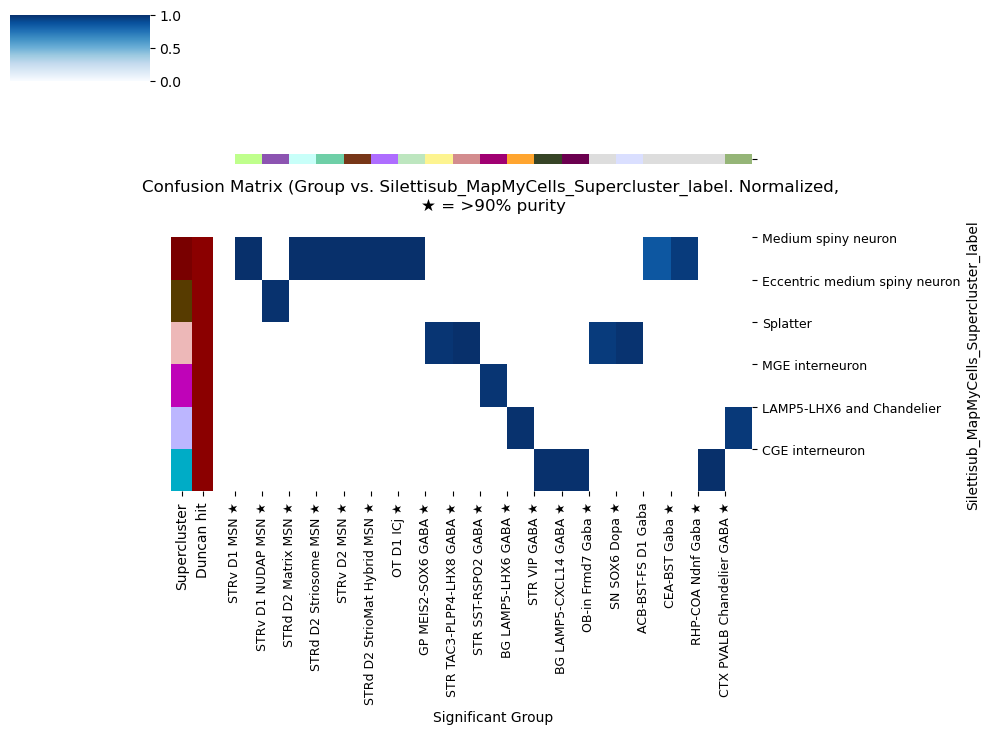

Keeping 66 out of 66 requested labels.


<Figure size 1000x1000 with 0 Axes>

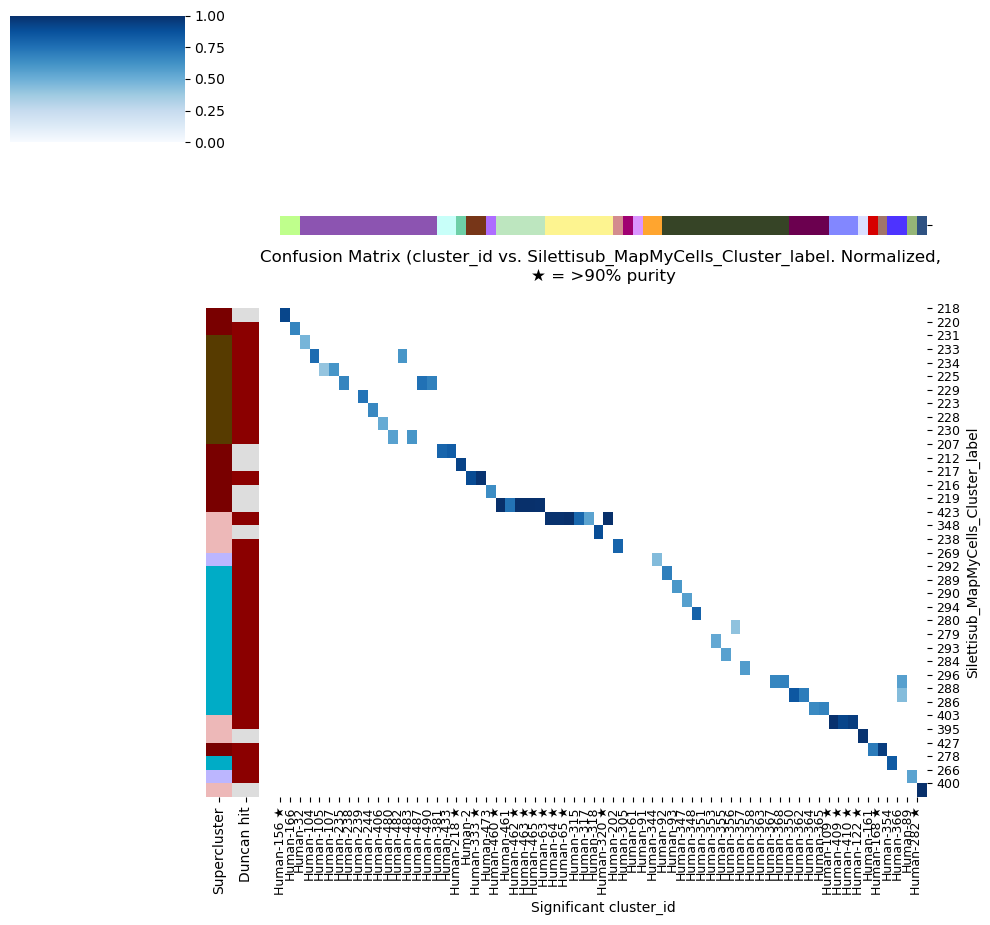

In [ ]:
## PLOT SECTION: Example for SCZ
## Represents the "candidate discoveries", clusters that we are detecting in thr Siletti et al's taxonomy, but not associated in the Duncan et al.

  ## GROUPS OBTAINED FROM THE BG TAXONOMY:
BG_groups_significant = ['STRv D1 NUDAP MSN', 'OB-in Frmd7 Gaba', 'SN SOX6 Dopa', 'STRv D1 MSN', 'ACB-BST-FS D1 Gaba', 'CEA-BST Gaba', 'STRv D2 MSN', 'STR TAC3-PLPP4-LHX8 GABA', 'STRd D2 Striosome MSN', 'BG Cholinergic GABA', 'STR SST-RSPO2 GABA', 'GP MEIS2-SOX6 GABA', 'BG LAMP5-LHX6 GABA', 'STR VIP GABA', 
                  'BG LAMP5-CXCL14 GABA', 'RHP-COA Ndnf Gaba', 'STRd D2 Matrix MSN', 'OT D1 ICj', 'STRd D2 StrioMat Hybrid MSN', 'STR PVALB-RSPO2 GABA', 'CTX PVALB Chandelier GABA']
  ## SUPERCLUSTERS ASSOCIATED IN THE DUNCAN ET AL.:
Duncan_superclusters_significant = ['MGE interneuron', 'CGE interneuron', 'Miscellaneous', 'LAMP5-LHX6 and Chandelier', 'Eccentric medium spiny neuron', 'Splatter', 'Upper-layer intratelencephalic', 'Medium spiny neuron', 'Deep-layer intratelencephalic', 'Deep-layer corticothalamic and 6b', 'Amygdala excitatory', 
               'Midbrain-derived inhibitory', 'Hippocampal CA1-3', 'Deep-layer near-projecting']


plot_confusion_matrix_sort_on_BG(
    adata=adata,
    group_col="Group",
    label_col="Silettisub_MapMyCells_Supercluster_label",
    manual_order=manual_order,  # your predefined row order
    reorder_cols="greedy",      # or "cluster", "none"
    purity_thresh=0.9,
    rotate_plot=True,
    figsize=(10, 8),
    B_G_significant=BG_groups_significant,
    Duncan_list=Duncan_superclusters_significant
    #save_path=f"{work_dir}/figures_BG/confusion_bgGroup_SilettiSupercluster.pdf",

)



  ## CLUSTERS OBTAINED WITH THE BG TAXONOMY:
raw_list_BG = ['Cluster104', 'Cluster105', 'Cluster107', 'Cluster109', 'Cluster122', 'Cluster156', 'Cluster161', 'Cluster166', 'Cluster168', 'Cluster2', 'Cluster202', 'Cluster218', 'Cluster235', 'Cluster238', 'Cluster239', 'Cluster244', 'Cluster282', 'Cluster305', 'Cluster315', 'Cluster317', 'Cluster318', 'Cluster32', 'Cluster320', 'Cluster333', 'Cluster344', 'Cluster347', 'Cluster348', 'Cluster350', 'Cluster351', 'Cluster353', 'Cluster354', 'Cluster355', 'Cluster356', 'Cluster357', 'Cluster358', 'Cluster362', 'Cluster363', 'Cluster364', 'Cluster365', 'Cluster366', 'Cluster367', 'Cluster368', 'Cluster381', 'Cluster406', 'Cluster409', 'Cluster410', 'Cluster433', 'Cluster460', 'Cluster461', 'Cluster462', 'Cluster463', 'Cluster465', 'Cluster473',
                   'Cluster480', 'Cluster482', 'Cluster483', 'Cluster487', 'Cluster490', 'Cluster61', 'Cluster63', 'Cluster64', 'Cluster65', 'Cluster89', 'Cluster91', 'Cluster92', 'Cluster93']

  ## CLUSTERS OBTAINED WITH THE DUNCAN ET AL:
raw_list_duncan = ['Cluster239', 'Cluster242', 'Cluster288', 'Cluster278', 'Cluster262', 'Cluster263', 'Cluster241', 'Cluster240', 'Cluster259', 'Cluster132', 'Cluster264', 'Cluster283', 'Cluster233', 'Cluster243', 'Cluster260', 'Cluster273', 'Cluster294', 'Cluster228', 'Cluster296', 'Cluster251', 'Cluster261', 'Cluster286', 'Cluster287',
                     'Cluster252', 'Cluster231', 'Cluster250', 'Cluster249', 'Cluster280', 'Cluster270', 'Cluster229', 'Cluster269', 'Cluster234', 'Cluster237', 'Cluster275', 'Cluster423', 'Cluster133', 'Cluster284', 'Cluster290', 'Cluster293', 'Cluster217', 'Cluster274', 'Cluster123', 'Cluster256', 'Cluster292', 'Cluster266', 'Cluster271','Cluster291', 'Cluster253', 'Cluster289', 'Cluster265', 'Cluster140', 'Cluster232', 'Cluster177', 'Cluster282', 'Cluster295', 'Cluster404', 'Cluster226', 'Cluster225', 'Cluster248', 'Cluster122', 'Cluster267', 'Cluster403', 'Cluster257', 'Cluster230', 'Cluster428', 'Cluster277', 'Cluster141', 'Cluster426', 'Cluster268', 'Cluster272',
                         'Cluster224', 'Cluster258', 'Cluster236', 'Cluster227', 'Cluster427', 'Cluster424', 'Cluster149', 'Cluster108', 'Cluster220', 'Cluster238', 'Cluster281', 'Cluster285', 'Cluster156', 'Cluster245', 'Cluster440', 'Cluster425', 'Cluster244', 'Cluster98', 'Cluster179', 'Cluster434', 'Cluster407', 'Cluster138', 'Cluster439', 'Cluster433',
                          'Cluster109', 'Cluster92', 'Cluster120', 'Cluster222', 'Cluster367', 'Cluster146', 'Cluster279', 'Cluster223', 'Cluster167', 'Cluster255', 'Cluster436', 'Cluster131', 'Cluster139'] # SCZ


Duncan_significant = [(x.replace("Cluster", "")) for x in raw_list_duncan]
B_G_significant = [x.replace("Cluster", "Human-") for x in raw_list_BG]

plot_confusion_matrix_sort_on_BG(
    adata=adata,
    group_col="cluster_id",
    label_col="Silettisub_MapMyCells_Cluster_label",
    manual_order=cluster_id_order,
    reorder_cols="greedy",      # or "cluster", "none"
    purity_thresh=0.9,
    rotate_plot=True,
    figsize=(10, 10),
    show_colorbar=False,
    B_G_significant=B_G_significant,
    Duncan_list=Duncan_significant
    #save_path=f"{work_dir}/figures_BG/confusion_BGclusterID_SilettiCluster.pdf",
)
 

In [11]:
def plot_confusion_matrix_sort_on_Duncan(
   adata,
   group_col="Group",
   label_col="siletti_label",
   manual_order=None,
   reorder_cols="greedy",  # Options: "greedy", "cluster", "none"
   purity_thresh=0.9,
   rotate_plot=False,      # Rotate heatmap view (flip x and y axis)
   figsize=(8, 14),
   cmap="YlGnBu",
   save_path=None,         # Save output path
   show_colorbar=True,     # Show or hide the colorbar
   min_mapping_threshold=None,  # NEW: filter labels never mapped > threshold
   Duncan_significant=None, #
   BG_list=None
):
   """
   Plot a confusion matrix between a cell type grouping and mapped reference labels.
   Colorbars indicate the groups and the supercluster  to which the groupings belong. 
   A second colorbar (for the columns) indicates whether the BG's cluster has a significant association in our analysis.
   

   Parameters
   ----------
   adata : AnnData
       The annotated data object containing obs columns for group and reference mapping.
   group_col : str
       The column in adata.obs for your cell type labels (rows of confusion matrix).
   label_col : str
       The column in adata.obs for mapped reference labels (columns of confusion matrix).
   manual_order : list or None
       Optional list specifying the order of group_col (rows).
   reorder_cols : str
       Column ordering method: "greedy", "cluster", or "none".
   purity_thresh : float
       Threshold for marking high-purity rows with a star.
   rotate_plot : bool
       If True, transpose the matrix only for visualization (flip axes).
   figsize : tuple
       Size of the figure (width, height).
   cmap : str
       Colormap for the heatmap.
   save_path : str or None
       If provided, saves the plot to this file path.
   show_colorbar : bool
       Whether to show the heatmap colorbar (legend).
   min_mapping_threshold : float or None
       If set, filters out label columns where no group maps above this threshold.
   Duncan_significant : list of strings
       list of Siletti's grouping significant in Duncan et al.'s study
   BG_list : list of strings
      list of BG grouping significant in our analysis
   """



   import pandas as pd
   import seaborn as sns
   import matplotlib.pyplot as plt



   ### I/ Construct confusion matrix (normalized)
   confusion_raw = pd.crosstab(adata.obs[group_col], adata.obs[label_col])
   confusion_norm = confusion_raw.div(confusion_raw.sum(axis=1), axis=0)
   confusion_norm = confusion_norm[confusion_norm.sum(axis=1) > 0]

   if Duncan_significant is not None:
    Duncan_significant = list(map(str, Duncan_significant))
    available_labels = confusion_norm.columns.astype(str)
    matched_labels = [label for label in Duncan_significant if label in available_labels.tolist()]

    if not matched_labels:
        raise ValueError(
            f"None of the labels in `label_include_list` matched the confusion matrix columns.\n"
            f"Available labels: {available_labels.tolist()}\n"
            f"Requested labels: {Duncan_significant}"
        )

    print(f"Keeping {len(matched_labels)} out of {len(Duncan_significant)} requested labels.")
    confusion_norm = confusion_norm.loc[:, matched_labels]  # TO FILTER THE SILETTI

   # Apply row order if provided
   if manual_order is not None:
       confusion_norm = confusion_norm.reindex([x for x in manual_order if x in confusion_norm.index])

   # Optional: filter labels never reaching mapping threshold
   if min_mapping_threshold is not None:
       filtered_cols = confusion_norm.columns[(confusion_norm > min_mapping_threshold).any(axis=0)]
       confusion_norm = confusion_norm[filtered_cols]

   # Step 2: Column reordering
   if reorder_cols == "greedy":
       best_match_per_row = confusion_norm.idxmax(axis=1)
       seen = set()
       ordered_labels = []
       for label in best_match_per_row:
           if label not in seen:
               ordered_labels.append(label)
               seen.add(label)
       remaining_labels = [label for label in confusion_norm.columns if label not in seen]
       final_label_order = ordered_labels + remaining_labels
       confusion_norm = confusion_norm[final_label_order]

   elif reorder_cols == "cluster":
       from scipy.cluster.hierarchy import linkage, leaves_list
       from scipy.spatial.distance import pdist
       col_linkage = linkage(pdist(confusion_norm.T, metric="euclidean"), method="average")
       col_order = leaves_list(col_linkage)
       ordered_labels = confusion_norm.columns[col_order]
       confusion_norm = confusion_norm[ordered_labels]

   elif reorder_cols == "none":
       pass
   else:
       raise ValueError(f"Unknown reorder_cols mode: {reorder_cols}")

   # Step 3: Compute purity
   max_fraction = confusion_norm.max(axis=1)
   pure_groups = max_fraction[max_fraction > purity_thresh].index.tolist()


   # Step 4: Rotate if needed (for plotting only)
   plot_matrix = confusion_norm.T if rotate_plot else confusion_norm
   plot_matrix = pd.DataFrame(plot_matrix)
   row_labels = plot_matrix.index.tolist()
   col_labels = plot_matrix.columns.tolist()


  ### II/ COLORBARS: ADDITIONAL INFO ON BASAL GANGLIA'S CELL TYPES: 
  ## Colorbar 1: Groups
  ## Colorbar 2: Significance of the Clusters in our analysis.

   # Upload annotations (cluster_id → Group)
   sheet_id = "12XOtSJnZruEkfrqHlN37L2XAaxnYLrpuAJwfz-JSjR8"
   gid = "1145771741"
   url_csv = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"

   annotations_df = pd.read_csv(url_csv)
   annotations_df = annotations_df[["cluster_id", "Neighborhood", "Class", "Subclass", "Group","Silettisub_MapMyCells_Subcluster_label", "Silettisub_MapMyCells_Cluster_label","Anatomical_region"]]
   annotations_df["cluster_id"] = "Human-" + annotations_df["cluster_id"].astype(int).astype(str)

   # Step 1: Generates color palette for the groups present in annotation
   unique_groups = annotations_df["Group"].dropna().unique()
   palette = cc.glasbey[:len(unique_groups)]
   group_to_color = dict(zip(unique_groups, palette))
   BG_set = set(BG_list)

   col_color_dict = {}

   # Step 2:  map Groups to col_labels
   if group_col == "cluster_id":
        cluster_to_group = annotations_df.set_index("cluster_id")["Group"].to_dict()
        col_color_dict["Group"] = pd.Series(col_labels, index=col_labels).map(
            lambda x: group_to_color.get(cluster_to_group.get(x, ""), "#DDDDDD")
        )

   elif group_col == "Group":
        col_color_dict["Group"] = pd.Series(col_labels, index=col_labels).map(
            lambda x: group_to_color.get(x, "#DDDDDD")
        )

   # Step 3: colorbar on the significance in our analysis
   col_color_dict["BG highlight"] = pd.Series(col_labels, index=col_labels).map(
       lambda x: "darkred" if x in BG_set else "#DDDDDD"
   )

   # Step 4 : Dataframe with both annotations
   col_colors = pd.DataFrame(col_color_dict).loc[col_labels]



   ### III/ COLORBARS: ADDITIONAL INFO ON SILETTI'S CLUSTERS
   row_color_dict = {}

  # Step 1: Generates a color palette for the superclusters present in adata.obs

   if "Silettisub_MapMyCells_Supercluster_label" in adata.obs:
    unique_superclusters = sorted(
        adata.obs["Silettisub_MapMyCells_Supercluster_label"]
        .dropna()
        .unique()
        .tolist()
    )
    palette = cc.glasbey[:len(unique_superclusters)]
    supercluster_to_color = dict(zip(unique_superclusters, palette))
   else:
        supercluster_to_color = {}

# Step 2: Maps superclusters to label_col
   if label_col == "Silettisub_MapMyCells_Cluster_label" and rotate_plot:
        mapping_df = (
            adata.obs[[label_col, "Silettisub_MapMyCells_Supercluster_label"]]
            .dropna()
            .drop_duplicates()
        )
        cluster_to_supercluster = mapping_df.set_index(label_col)["Silettisub_MapMyCells_Supercluster_label"].to_dict()

        row_color_dict["Supercluster"] = pd.Series(row_labels, index=row_labels).map(
            lambda x: supercluster_to_color.get(cluster_to_supercluster.get(x, ""), "#DDDDDD")
        )

   elif label_col == "Silettisub_MapMyCells_Supercluster_label":
        row_color_dict["Supercluster"] = pd.Series(row_labels, index=row_labels).map(
            lambda x: supercluster_to_color.get(x, "#DDDDDD")
        )

# Step 3: Dataframe with the annotation:
   row_colors = pd.DataFrame(row_color_dict)
    


# Step 4: Keep only clusters with a mapping above 0.4 for the final representation: 

   mask = plot_matrix <= 0.4

   # Filter columns
   cols_to_keep = mask.columns[~mask.all(axis=0)]
   plot_matrix = plot_matrix[cols_to_keep]
   mask = mask[cols_to_keep]
   col_colors = col_colors.loc[cols_to_keep]

   mask = plot_matrix <= 0.4 # Recompute mask after filtering
   rows_to_keep = mask.index[~mask.all(axis=1)]
   plot_matrix = plot_matrix.loc[rows_to_keep]
   mask = mask.loc[rows_to_keep]
   
   # Filter rows
   row_colors = row_colors.loc[rows_to_keep]
   row_labels = rows_to_keep.tolist()
   col_labels = cols_to_keep.tolist()

   # Identify high-purity columns ()
   highlight_targets = [col for col in col_labels if col in pure_groups]


   ### IV/ PLOT

   fig_width, fig_height = figsize if not rotate_plot else (figsize[1], figsize[0])
   plt.figure(figsize=(fig_width, fig_height))
   #ax = sns.heatmap(plot_matrix, cmap=cmap, linewidths=0.1, cbar=show_colorbar)

   g = sns.clustermap(
    plot_matrix,
    row_cluster=False, col_cluster=False,
    col_colors=col_colors,
    row_colors=row_colors,
    cmap="Blues",
    figsize=figsize,
    cbar_pos=(0.02, 0.8, 0.01, 0.25),
    mask = mask,
    vmin = 0,
    vmax = 1
    )
   
   ax = g.ax_heatmap

   ax.set_yticks(range(len(row_labels)))
   ax.set_yticklabels(row_labels, rotation=0, fontsize=9)

   ax.set_xticks(range(len(col_labels)))
   highlight_targets = pure_groups if not rotate_plot else [
       col for col in col_labels if col in pure_groups
   ]
   new_xticklabels = [
       col + " ★" if col in highlight_targets else col for col in col_labels
   ]
   ax.set_xticklabels(new_xticklabels, rotation=90, fontsize=9)



   xlabel = group_col if rotate_plot else label_col
   ylabel = label_col if rotate_plot else group_col
   ax.set_xlabel(xlabel)
   ax.set_ylabel(f"Significant {ylabel}")

   ax.set_title(
    f"Confusion Matrix ({group_col} vs. {label_col}. Normalized, \n★ = >{int(purity_thresh * 100)}% purity",
    pad=20,
    loc='center' 
    )
   plt.tight_layout()

   if save_path is not None:
       plt.savefig(save_path, dpi=300, bbox_inches='tight')
       print(f"Figure saved to: {save_path}")
   else:
       plt.show() 

Keeping 13 out of 14 requested labels.


<Figure size 800x1400 with 0 Axes>

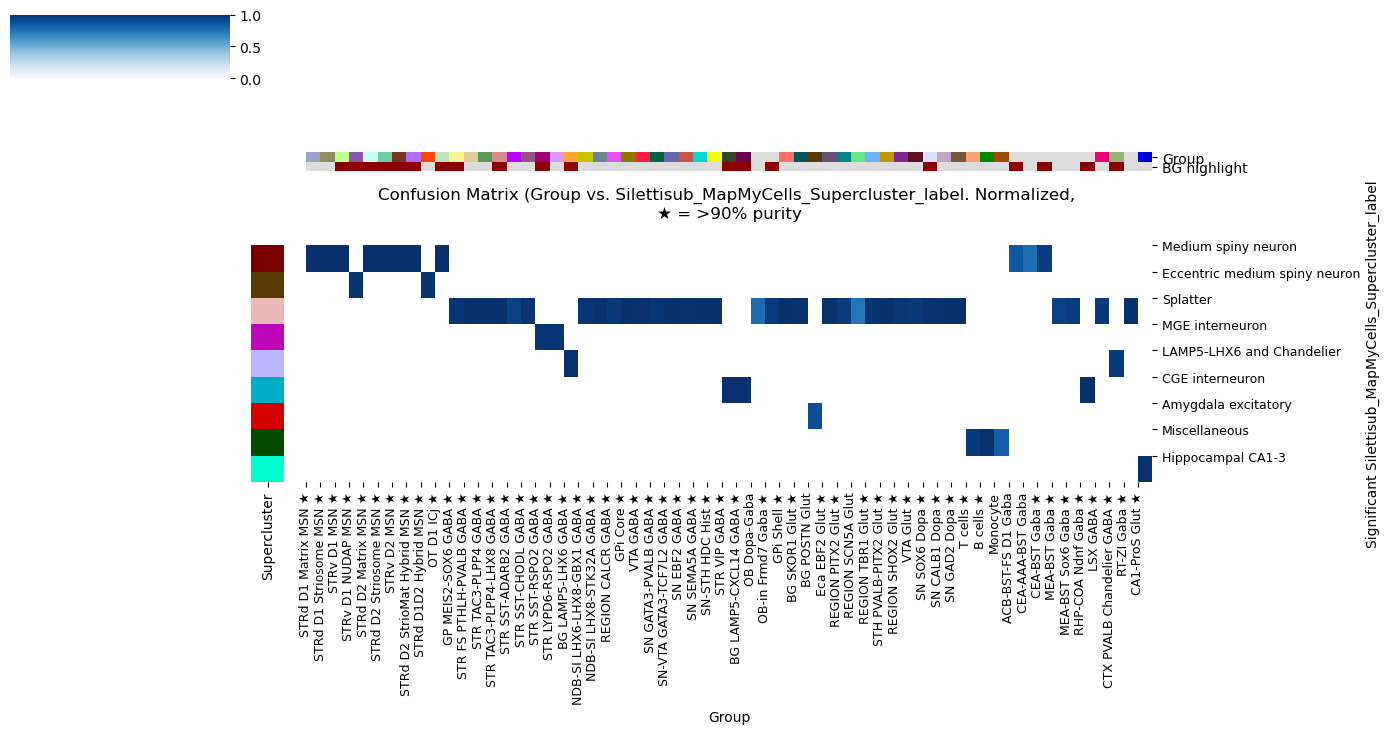

Keeping 90 out of 107 requested labels.


<Figure size 1500x1500 with 0 Axes>

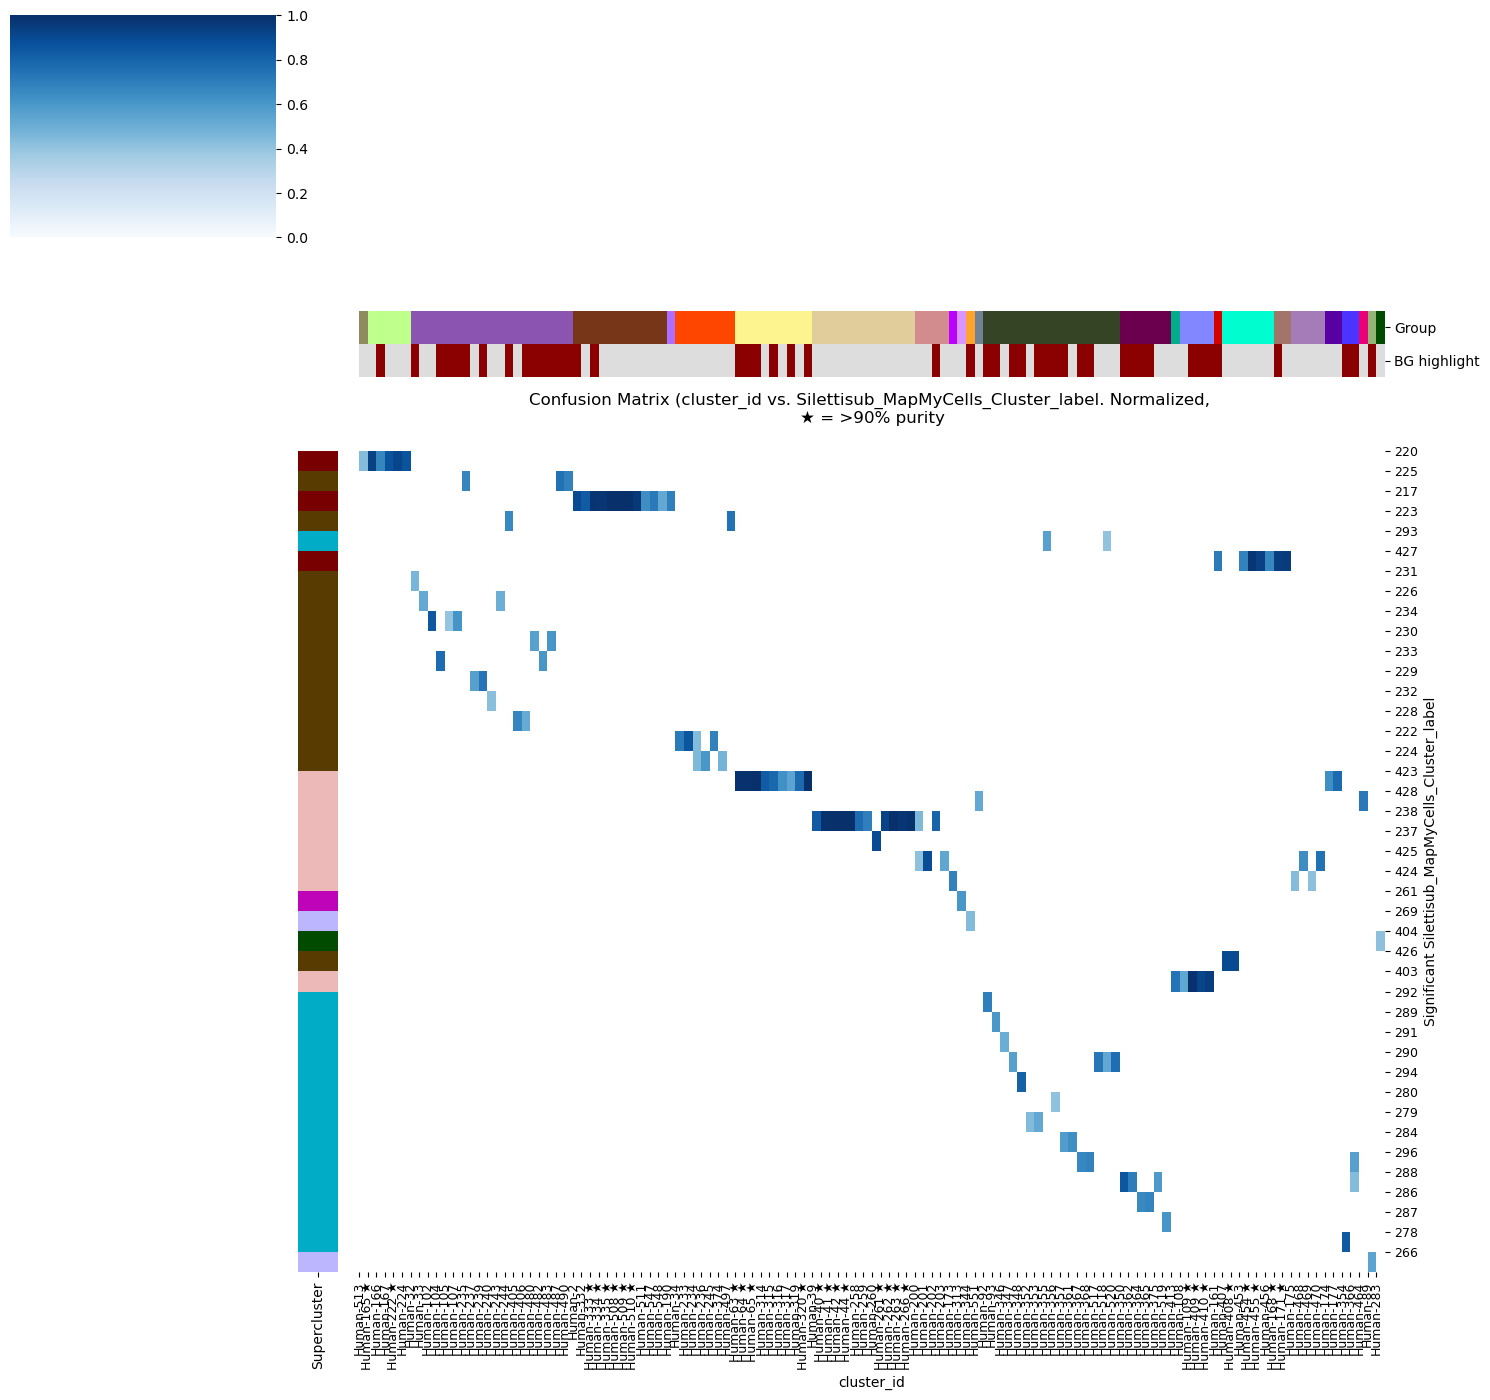

In [12]:
## PLOT SECTION: Example for SCZ
## Represents the clusters from the BG taxonomy, mapping to significant Siletti's clusters, that we are potentially missing.

## FOR SCZ
  ## GROUPS OBTAINED FROM THE BG TAXONOMY:
BG_groups_significant = ['STRv D1 NUDAP MSN', 'OB-in Frmd7 Gaba', 'SN SOX6 Dopa', 'STRv D1 MSN', 'ACB-BST-FS D1 Gaba', 'CEA-BST Gaba', 'STRv D2 MSN', 'STR TAC3-PLPP4-LHX8 GABA', 'STRd D2 Striosome MSN', 'BG Cholinergic GABA', 'STR SST-RSPO2 GABA', 'GP MEIS2-SOX6 GABA', 'BG LAMP5-LHX6 GABA', 'STR VIP GABA', 
                  'BG LAMP5-CXCL14 GABA', 'RHP-COA Ndnf Gaba', 'STRd D2 Matrix MSN', 'OT D1 ICj', 'STRd D2 StrioMat Hybrid MSN', 'STR PVALB-RSPO2 GABA', 'CTX PVALB Chandelier GABA']
  ## SUPERCLUSTERS ASSOCIATED IN THE DUNCAN ET AL.:
Duncan_superclusters_significant = ['MGE interneuron', 'CGE interneuron', 'Miscellaneous', 'LAMP5-LHX6 and Chandelier', 'Eccentric medium spiny neuron', 'Splatter', 'Upper-layer intratelencephalic', 'Medium spiny neuron', 'Deep-layer intratelencephalic', 'Deep-layer corticothalamic and 6b', 'Amygdala excitatory', 
               'Midbrain-derived inhibitory', 'Hippocampal CA1-3', 'Deep-layer near-projecting']

plot_confusion_matrix_sort_on_Duncan(
    adata=adata,
    group_col="Group",
    label_col="Silettisub_MapMyCells_Supercluster_label",
    manual_order=manual_order,  # your predefined row order
    reorder_cols="greedy",      # or "cluster", "none"
    purity_thresh=0.9,
    rotate_plot=True,
    figsize=(14, 8),
    Duncan_significant=Duncan_superclusters_significant,
    BG_list=BG_groups_significant
    #save_path=f"{work_dir}/figures_BG/confusion_bgGroup_SilettiSupercluster.pdf",

)


 ## CLUSTERS OBTAINED WITH THE BG TAXONOMY:
raw_list_BG = ['Cluster104', 'Cluster105', 'Cluster107', 'Cluster109', 'Cluster122', 'Cluster156', 'Cluster161', 'Cluster166', 'Cluster168', 'Cluster2', 'Cluster202', 'Cluster218', 'Cluster235', 'Cluster238', 'Cluster239', 'Cluster244', 'Cluster282', 'Cluster305', 'Cluster315', 'Cluster317', 'Cluster318', 'Cluster32', 'Cluster320', 'Cluster333', 'Cluster344', 'Cluster347', 'Cluster348', 'Cluster350', 'Cluster351', 'Cluster353', 'Cluster354', 'Cluster355', 'Cluster356', 'Cluster357', 'Cluster358', 'Cluster362', 'Cluster363', 'Cluster364', 'Cluster365', 'Cluster366', 'Cluster367', 'Cluster368', 'Cluster381', 'Cluster406', 'Cluster409', 'Cluster410', 'Cluster433', 'Cluster460', 'Cluster461', 'Cluster462', 'Cluster463', 'Cluster465', 'Cluster473',
                   'Cluster480', 'Cluster482', 'Cluster483', 'Cluster487', 'Cluster490', 'Cluster61', 'Cluster63', 'Cluster64', 'Cluster65', 'Cluster89', 'Cluster91', 'Cluster92', 'Cluster93']

  ## CLUSTERS OBTAINED WITH THE DUNCAN ET AL:
raw_list_siletti = ['Cluster239', 'Cluster242', 'Cluster288', 'Cluster278', 'Cluster262', 'Cluster263', 'Cluster241', 'Cluster240', 'Cluster259', 'Cluster132', 'Cluster264', 'Cluster283', 'Cluster233', 'Cluster243', 'Cluster260', 'Cluster273', 'Cluster294', 'Cluster228', 'Cluster296', 'Cluster251', 'Cluster261', 'Cluster286', 'Cluster287',
                     'Cluster252', 'Cluster231', 'Cluster250', 'Cluster249', 'Cluster280', 'Cluster270', 'Cluster229', 'Cluster269', 'Cluster234', 'Cluster237', 'Cluster275', 'Cluster423', 'Cluster133', 'Cluster284', 'Cluster290', 'Cluster293', 'Cluster217', 'Cluster274', 'Cluster123', 'Cluster256', 'Cluster292', 'Cluster266', 'Cluster271','Cluster291', 'Cluster253', 'Cluster289', 'Cluster265', 'Cluster140', 'Cluster232', 'Cluster177', 'Cluster282', 'Cluster295', 'Cluster404', 'Cluster226', 'Cluster225', 'Cluster248', 'Cluster122', 'Cluster267', 'Cluster403', 'Cluster257', 'Cluster230', 'Cluster428', 'Cluster277', 'Cluster141', 'Cluster426', 'Cluster268', 'Cluster272',
                         'Cluster224', 'Cluster258', 'Cluster236', 'Cluster227', 'Cluster427', 'Cluster424', 'Cluster149', 'Cluster108', 'Cluster220', 'Cluster238', 'Cluster281', 'Cluster285', 'Cluster156', 'Cluster245', 'Cluster440', 'Cluster425', 'Cluster244', 'Cluster98', 'Cluster179', 'Cluster434', 'Cluster407', 'Cluster138', 'Cluster439', 'Cluster433',
                          'Cluster109', 'Cluster92', 'Cluster120', 'Cluster222', 'Cluster367', 'Cluster146', 'Cluster279', 'Cluster223', 'Cluster167', 'Cluster255', 'Cluster436', 'Cluster131', 'Cluster139'] # SCZ


Duncan_clusters_significant= [(x.replace("Cluster", "")) for x in raw_list_siletti]
BG_clusters_significant = [x.replace("Cluster", "Human-") for x in raw_list_BG]

plot_confusion_matrix_sort_on_Duncan(
    adata=adata,
    group_col="cluster_id",
    label_col="Silettisub_MapMyCells_Cluster_label",
    manual_order=cluster_id_order,
    reorder_cols="greedy",      # or "cluster", "none"
    purity_thresh=0.9,
    rotate_plot=True,
    figsize=(15, 15),
    show_colorbar=False,
    Duncan_significant=Duncan_clusters_significant,
    BG_list=BG_clusters_significant
    #save_path=f"{work_dir}/figures_BG/confusion_BGclusterID_SilettiCluster.pdf",
)